## Objectives

This notebook details the process to detect outliers in one time series data using the time series decomposition method.
- Input: a csv file that contains three columns: Account (account id), Month (calendar month), Value (numerical column to detect outliers from)
- Output: visualizations of outliers detected via STL and multiple methods

## Load packages

In [1]:
library(tidyverse)
library(anomalize)
library(ggQC)
library(anomalize)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Read in dataset

In [2]:
# read in the csv file which contains the prorated and imputed KWH_Consumption data for NYCHA accounts
tb_all = read_csv("../output/NYCHA_TS.csv")

# filter out unnecessary columns
tb_all = select(tb_all, c('Account', 'Month', 'Value'))

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  X1 = col_double(),
  Account = col_character(),
  Month = col_date(format = ""),
  Value = col_double()
)


## Get the list of accounts in the input file

In [3]:
accounts = tb_all %>% group_by(Account) 
accounts <- accounts %>% summarise(counts = n(), na_counts = sum(is.na(Value)))
accounts <- mutate(accounts, na_perc = na_counts/counts)

## Fill the missing values in the "Value" column with 0

#### the R package Anomalize requires the no missing value in the input dataframe

In [4]:
tb_all <- mutate(tb_all, Value = ifelse(is.na(Value), 0, Value))

## Use one account as an example to detect and visualize the outliers

In [39]:
i = match('165.0 - BLD 03_90327795', accounts$Account)

### Apply STL decomposition to the time series

In [70]:
ts = select(filter(tb_all, Account == accounts$Account[[i]]), 'Month', 'Value')

# apply STL decomposition
ts_anomalized <- ts %>%
    time_decompose(Value, method = 'stl', merge = TRUE) 
#     anomalize(remainder, method = 'iqr') %>%
#     time_recompose()

Converting from tbl_df to tbl_time.
Auto-index message: index = Month
frequency = 12 months
trend = 42 months


In [71]:
ts_anomalized$Account = accounts$Account[[i]]
ts_anomalized$Missing_Value = ts_anomalized$Value == 0

ts_anomalized <- rename(ts_anomalized, Calendar_Month = Month)
ts_anomalized <- ts_anomalized[, c('Account', 'Calendar_Month', 'Missing_Value', 'observed', 'trend', 'season', 'remainder')]



In [73]:
# Calculate residuals
iqr_3X <- ts_anomalized %>%
        anomalize(remainder, method = 'iqr', alpha = 0.05) %>%
        time_recompose()

### Visualize the outliers detected using the Inter Quantile Range (IQR) method with 3X threshold
- residual values beyond 3 times the interquartile range from the 75th and 25th percentiles are considered as outliers

#### Plot the total value and all three components over time, with the outlier points highlighted in red circles

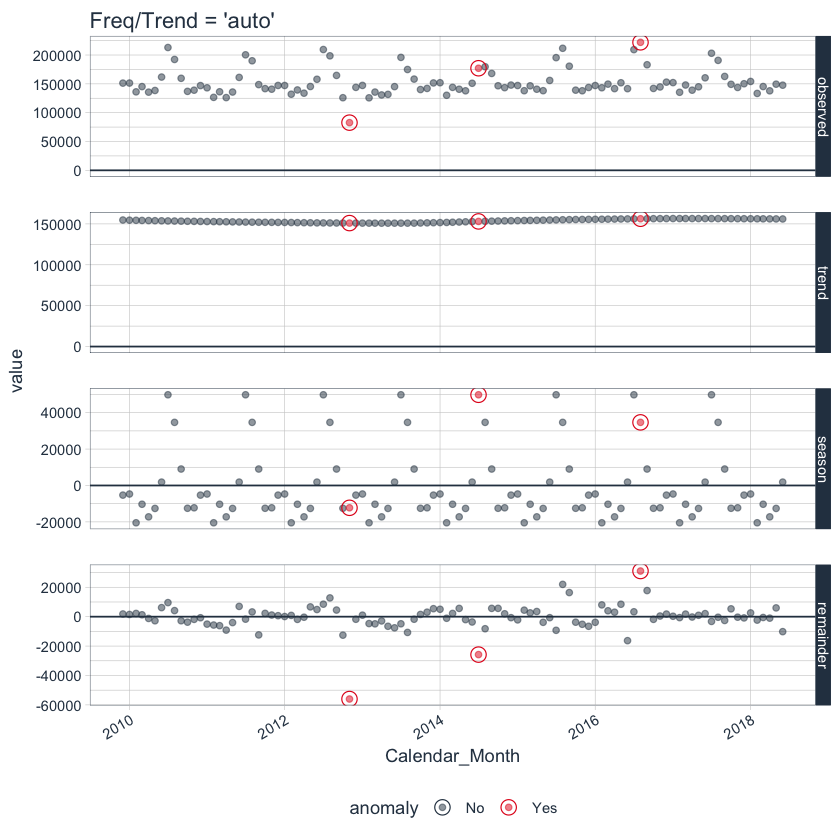

In [75]:
p1 <- iqr_3X %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Freq/Trend = 'auto'")

p1

#### plotting configuration of the residual plots that highlights detected outliers

In [8]:
# ploting function for anomaly plots
ggsetup <- function(data) {
    data %>%
        ggplot(aes(rank, value, color = outlier)) +
        geom_point() +
        geom_line(aes(y = limit_upper), color = "red", linetype = 2) +
        geom_line(aes(y = limit_lower), color = "red", linetype = 2) +
        geom_text(aes(label = index), vjust = -1.25) +
        theme_bw() +
        scale_color_manual(values = c("No" = "#2c3e50", "Yes" = "#e31a1c")) +
        expand_limits(y = 13) +
        theme(legend.position = "bottom")
}

#### Residual Plot - IQR 3X

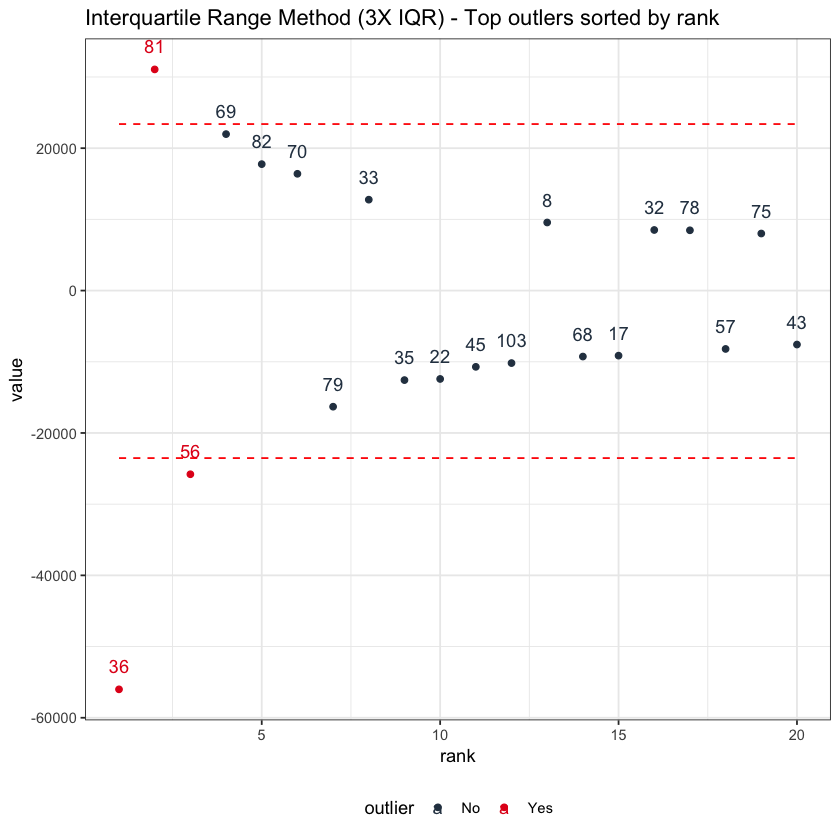

In [76]:
outliers <- iqr(ts_anomalized$remainder, verbose = TRUE, alpha = 0.05)$outlier_report
outliers %>% 
    ggsetup() +
    ggtitle("Interquartile Range Method (3X IQR) - Top outlers sorted by rank") 

### Visualize the outliers detected using the Inter Quantile Range (IQR) method with 6X threshold
- residual values beyond 6 times the interquartile range from the 75th and 25th percentiles are considered as outliers

In [78]:
# Calculate residuals
iqr_6X <- ts_anomalized %>%
        anomalize(remainder, method = 'iqr', alpha = 0.025) %>%
        time_recompose()

#### Plot the total value and all three components over time, with the outlier points highlighted in red circles

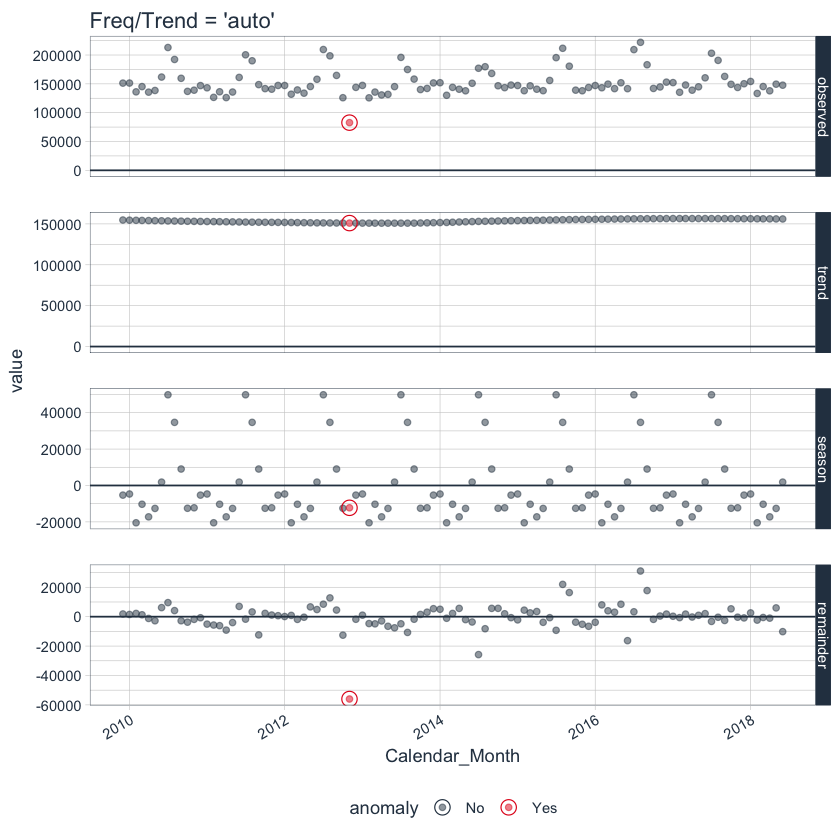

In [79]:
p2 <- iqr_6X %>%
    plot_anomaly_decomposition(alpha_dot = 0.5) +
    ggtitle("Freq/Trend = 'auto'")

p2

#### Residual Plot - IQR 6X

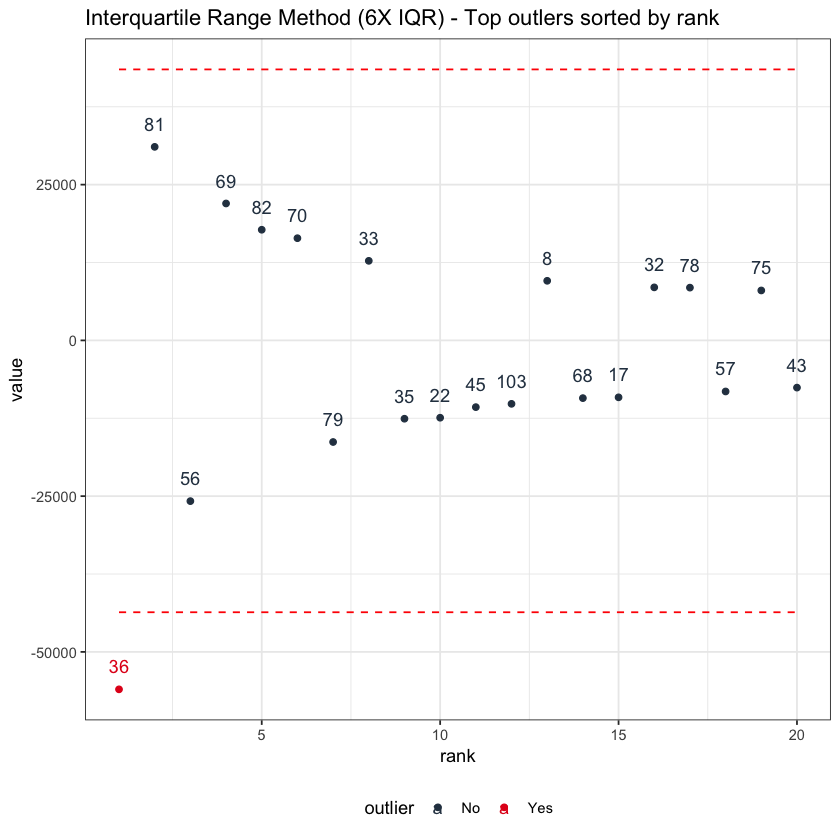

In [80]:
outliers <- iqr(ts_anomalized$remainder, verbose = TRUE, alpha = 0.025)$outlier_report
outliers %>% 
    ggsetup() +
    ggtitle("Interquartile Range Method (6X IQR) - Top outlers sorted by rank") 

### Visualize the outliers detected using the XmR (Individual Moving Range) chart

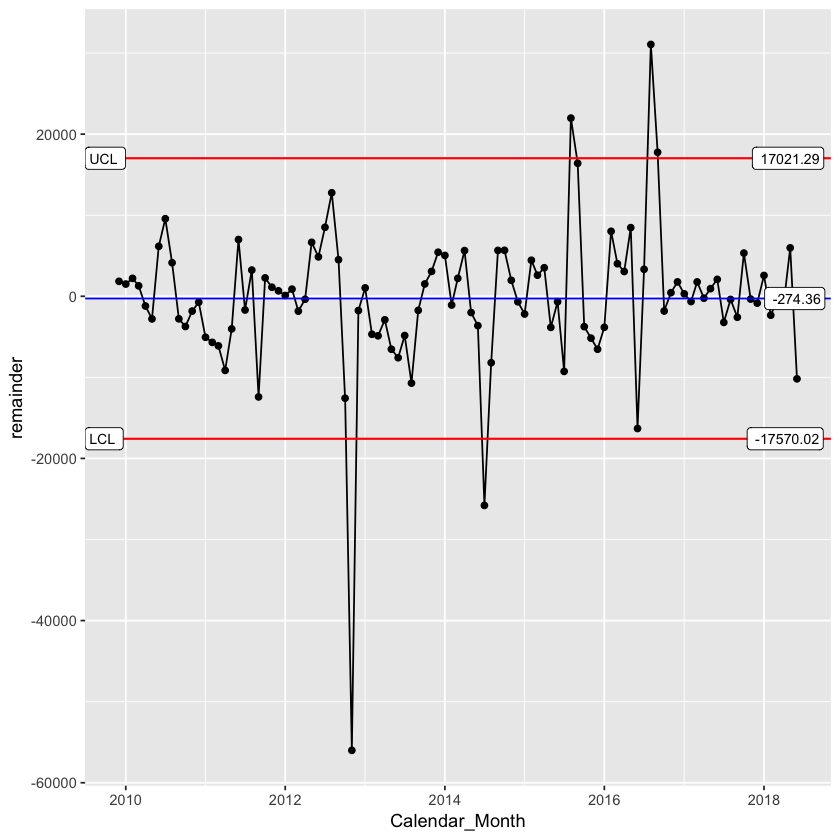

In [82]:
x_Plot <- ggplot(ts_anomalized, aes(x = Calendar_Month, y = remainder)) + geom_point() + geom_line() + 
  stat_QC(method = 'XmR', auto.label = T, label.digits = 2, show.1n2.sigma = F) 
x_Plot

### Assign ranking to the outliers detected

#### Define a function to calculate the deviation of a residual value from the limit values

In [83]:
cal_dev <- function(residual, upper, lower) {
  if (residual < lower) {
    return(lower - residual)
  } else if (residual > upper) {
    return(residual - upper)
  } else {
    return (NA)
  }
}

#### Lable and rank the outliers detected from the 3 methods and save the info in a tibble seprately

In [86]:
iqr_3X <- iqr_3X[, c('Account', 'Calendar_Month', 'remainder', 'remainder_l1', 'remainder_l2', 'anomaly')]

# Add outlier indicator
iqr_3X <- rename(iqr_3X, Residual = remainder, Lower = remainder_l1, Upper = remainder_l2, Anomaly = anomaly)
iqr_3X <- mutate(iqr_3X, Anomaly = ifelse(Anomaly == "Yes", TRUE, FALSE))

# Calculate deviation from limit
iqr_3X$Dev <- mapply(cal_dev, iqr_3X$Residual, iqr_3X$Upper, iqr_3X$Lower)
iqr_3X <- arrange(iqr_3X, desc(Dev))

# Add ranking based on the residual value's deviation from the natural limit
iqr_3X$Rank = seq(1:nrow(iqr_3X))
iqr_3X[is.na(iqr_3X$Dev), ]$Rank <- NA

In [87]:
iqr_6X <- iqr_6X[, c('Account', 'Calendar_Month', 'remainder', 'remainder_l1', 'remainder_l2', 'anomaly')]
iqr_6X <- rename(iqr_6X, Residual = remainder, Lower = remainder_l1, Upper = remainder_l2, Anomaly = anomaly)

# Add outlier indicator
iqr_6X <- mutate(iqr_6X, Anomaly = ifelse(Anomaly == "Yes", TRUE, FALSE))

# Calculate deviation from limit
iqr_6X$Dev <- mapply(cal_dev, iqr_6X$Residual, iqr_6X$Upper, iqr_6X$Lower)
iqr_6X <- arrange(iqr_6X, desc(Dev))

# Add ranking based on the residual value's deviation from the natural limit
iqr_6X$Rank = seq(1:nrow(iqr_6X))
iqr_6X[is.na(iqr_6X$Dev), ]$Rank <- NA

In [91]:
ctrl_limits <- QC_Lines(data = ts_anomalized$remainder, method = "XmR")  
ctrl_limits <- ctrl_limits[, c('xBar_one_LCL', 'xBar_one_UCL')]
ctrl_limits <- rename(ctrl_limits, Lower= xBar_one_LCL, Upper = xBar_one_UCL)
xmr_mean <- cbind(ts_anomalized[, c('Account', 'Calendar_Month', 'remainder')], ctrl_limits)
xmr_mean <- rename(xmr_mean, Residual = remainder)

# Calculate deviation from limit
xmr_mean$Dev <- mapply(cal_dev, xmr_mean$Residual, xmr_mean$Upper, xmr_mean$Lower)
xmr_mean <- arrange(xmr_mean, desc(Dev))

# Add ranking based on the residual value's deviation from the natural limit
xmr_mean$Rank = seq(1:nrow(xmr_mean))
xmr_mean[is.na(xmr_mean$Dev), ]$Rank <- NA

# Add outlier indicator
xmr_mean <- mutate(xmr_mean, Anomaly = ifelse(is.na(Dev), FALSE, TRUE))

In [92]:
# rename the columns
iqr_3X <- rename(iqr_3X, Lower_3X = Lower, Upper_3X = Upper, Anomaly_3X = Anomaly, Dev_3X = Dev, Rank_3X = Rank)
iqr_6X <- rename(iqr_6X, Lower_6X = Lower, Upper_6X = Upper, Anomaly_6X = Anomaly, Dev_6X = Dev, Rank_6X = Rank)
xmr_mean <- rename(xmr_mean, Lower_xmr = Lower, Upper_xmr = Upper, Anomaly_xmr = Anomaly, Dev_xmr = Dev, Rank_xmr = Rank)

ts_anomalized <- rename(ts_anomalized, Total = observed, Trend = trend, Seasonal = season
   , Residual = remainder)
ts_anomalized <- ts_anomalized[, c('Account', 'Calendar_Month', 'Missing_Value', 'Total', 'Trend', 'Seasonal', 'Residual')]

#### Combine the results of 3 methods to get a final tibble named "result"

In [106]:
result <- 
ts_anomalized[c('Account', 'Calendar_Month', 'Missing_Value', 'Total', 'Trend', 'Seasonal', 'Residual')] %>% 
    inner_join(iqr_3X[, -3], by = c('Account', 'Calendar_Month')) %>%
    inner_join(iqr_6X[, -3], by = c('Account', 'Calendar_Month')) %>%
    inner_join(xmr_mean[, -3], by = c('Account', 'Calendar_Month')) 

# considered as an outlier if 
#     1) STL_6X outputs it as an outliers OR
#     2) STL_6X outputs it as a normal point but both other two methods output it as an outlier
result <- mutate(result
    , Anomaly_Voted = ifelse(((Anomaly_6X == TRUE) | ((Anomaly_6X == FALSE) & (Anomaly_xmr == TRUE & Anomaly_3X == TRUE))), TRUE, FALSE)
)

# weighted rank of the outlier
result <- 
    mutate(result, Rank_Weighted = ifelse(is.na(Rank_6X), (Rank_3X + Rank_xmr)/2, Rank_6X))

In [108]:
head(result)

Account,Calendar_Month,Missing_Value,Total,Trend,Seasonal,Residual,Lower_3X,Upper_3X,Anomaly_3X,⋯,Anomaly_6X,Dev_6X,Rank_6X,Lower_xmr,Upper_xmr,Dev_xmr,Rank_xmr,Anomaly_xmr,Anomaly_Voted,Rank_Weighted
165.0 - BLD 03_90327795,2009-12-01,FALSE,151280.0,154728.3,-5292.352,1844.047,-23528,23388.25,FALSE,⋯,FALSE,NA,NA,-17570.02,17021.29,NA,NA,FALSE,FALSE,NA
165.0 - BLD 03_90327795,2010-01-01,FALSE,151382.9,154562.4,-4686.829,1507.255,-23528,23388.25,FALSE,⋯,FALSE,NA,NA,-17570.02,17021.29,NA,NA,FALSE,FALSE,NA
165.0 - BLD 03_90327795,2010-02-01,FALSE,136106.8,154396.6,-20499.522,2209.761,-23528,23388.25,FALSE,⋯,FALSE,NA,NA,-17570.02,17021.29,NA,NA,FALSE,FALSE,NA
165.0 - BLD 03_90327795,2010-03-01,FALSE,145211.0,154230.7,-10309.362,1289.627,-23528,23388.25,FALSE,⋯,FALSE,NA,NA,-17570.02,17021.29,NA,NA,FALSE,FALSE,NA
165.0 - BLD 03_90327795,2010-04-01,FALSE,135622.2,154064.8,-17242.700,-1199.961,-23528,23388.25,FALSE,⋯,FALSE,NA,NA,-17570.02,17021.29,NA,NA,FALSE,FALSE,NA
165.0 - BLD 03_90327795,2010-05-01,FALSE,138498.6,153898.9,-12610.265,-2790.101,-23528,23388.25,FALSE,⋯,FALSE,NA,NA,-17570.02,17021.29,NA,NA,FALSE,FALSE,NA


## Summarize the outliers detected in all accounts

#### When you have data for multiple accounts, after looping through all the accounts with the above methods, we can summarize the percentage of data points identified as outliers with the following codes
- input: results_stl (a list of tibbles that contain the result for each account)
- output: summary_stl (a tibble that summarizes the information of each account, including # of data points, # of missing values, # of outliers detected, percentage of outliers detected etc.)

In [ ]:
points = lapply(results_stl, function(i) nrow(i))
anoamly_counts = lapply(results_stl, function(i) nrow(filter(i, Anomaly_Voted == TRUE)))
na_counts = lapply(results_stl, function(i) nrow(filter(i, Missing_Value == TRUE)))
anomaly_non_na_counts = lapply(results_stl, function(i) nrow(filter(i, (Anomaly_Voted == TRUE) & (Missing_Value == FALSE))))
anomaly_na_counts = lapply(results_stl, function(i) nrow(filter(i, (Anomaly_Voted == TRUE) & (Missing_Value == TRUE))))
na_non_anomaly_counts = lapply(results_stl, function(i) nrow(filter(i, (Anomaly_Voted == FALSE) & (Missing_Value == TRUE))))

summary_stl = tibble('account' = accounts$Account, 'points' = unlist(points)
                     , 'na' = unlist(na_counts)
                     , 'anomalies' = unlist(anoamly_counts), 'anomalies_non_na' = unlist(anomaly_non_na_counts)
                     , 'anomalies_na' = unlist(anomaly_na_counts)
                     , 'na_non_anomaly' = unlist(na_non_anomaly_counts)
                    )

In [ ]:
summary_stl <- mutate(summary_stl, na_perc = na/points)
summary_stl = mutate(summary_stl, anom_perc = anomalies_non_na /(points))
summary_stl = mutate(summary_stl, na_recall = anomalies_na /(na))
summary(summary_stl$anom_perc)

In [ ]:
hist(summary_stl$anom_perc * 100,
      main="Frequency count of % of anomalies, Decomposition",
      xlab="% of anomalies detected",
      ylab="Absolute frequency",
#       breaks=100,
      col="lightblue",
      freq=TRUE,                            # freq=FALSE means to plot density, not counts
      xaxt="n")                              # xaxt="n" means "x axis tick marks == no"
axis(side=1, at=seq(0, 50, by = 1))                        